# Traffic Prediction With Multilayer Perceptron

This notebook utilies Multilayer Perceptron to forecast the traffic frequency of a certain area (CA).

 It also performs some data exploration, pre-processing and then uses ensemble methods to improve model predictions

# Import all necessary libraries

In [116]:
# Install visualkeras to enable us visualize  in 3D
!pip install visualkeras

In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from keras.regularizers import l2
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor


# Data Loading

In [118]:
#load data from drive
from google.colab import drive
drive.mount('/content/drive')
traffic = pd.read_csv('/content/drive/My Drive/Traffic prediction/train14820.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Inspect the data

In [119]:
# Display traffic frequency per hour
interval = 12  # Skip every 12 rows
traffic_hourly = traffic.iloc[::interval].head(25)
print(traffic_hourly.head(23))

               timestamp  hourly_traffic_count
0    2015-10-04 00:00:00                    16
12   2015-10-04 01:00:00                    11
24   2015-10-04 02:00:00                     3
36   2015-10-04 03:00:00                     5
48   2015-10-04 04:00:00                     4
60   2015-10-04 05:00:00                     6
72   2015-10-04 06:00:00                    11
84   2015-10-04 07:00:00                    12
96   2015-10-04 08:00:00                    21
108  2015-10-04 09:00:00                    17
120  2015-10-04 10:00:00                    26
132  2015-10-04 11:00:00                    23
144  2015-10-04 12:00:00                    25
156  2015-10-04 13:00:00                    22
168  2015-10-04 14:00:00                    26
180  2015-10-04 15:00:00                    32
192  2015-10-04 16:00:00                    35
204  2015-10-04 17:00:00                    42
216  2015-10-04 18:00:00                    16
228  2015-10-04 19:00:00                    29
240  2015-10-

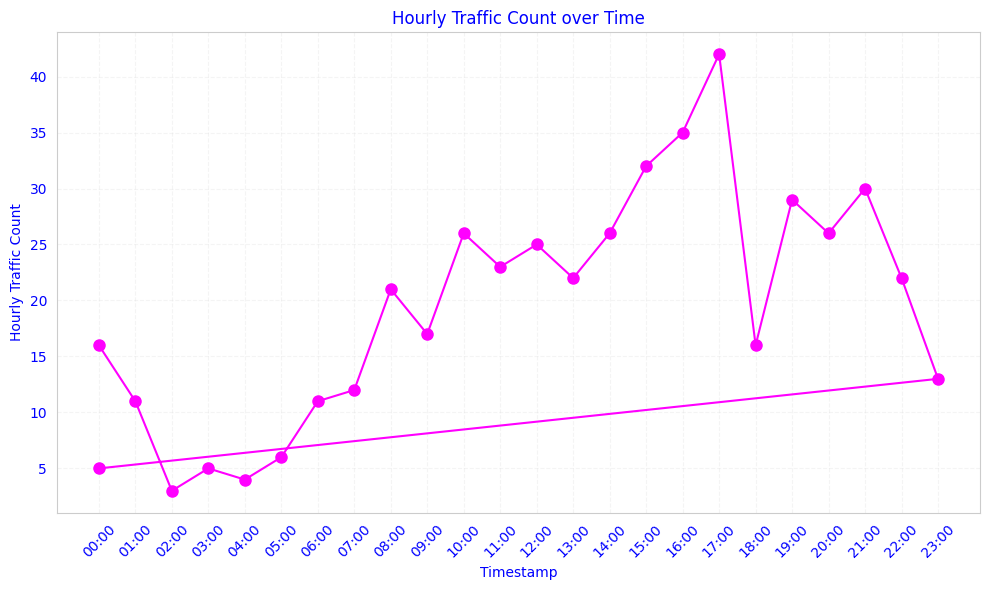

In [120]:
# Visualize traffic count data
timestamps = traffic_hourly['timestamp']

#Visualize only the traffic time
timestamps = timestamps.str[11:16]
traffic_counts = traffic_hourly['hourly_traffic_count']

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(timestamps, traffic_counts, color='magenta', marker='o', linestyle='-', markersize=8)
plt.title('Hourly Traffic Count over Time', color= 'blue')
plt.xlabel('Timestamp', color='blue')
plt.ylabel('Hourly Traffic Count', color='blue')
plt.xticks(rotation=45, color= 'blue')
plt.yticks(fontsize=10, color='blue')
plt.grid(True, linestyle='--', alpha=0.2)
plt.tight_layout()
plt.show()


# Change the index of the dataset to make more sense of the data

In [127]:
traffic1 = traffic.reset_index()['hourly_traffic_count']
traffic1.head()

0    16
1    10
2     5
3    14
4    12
Name: hourly_traffic_count, dtype: int64

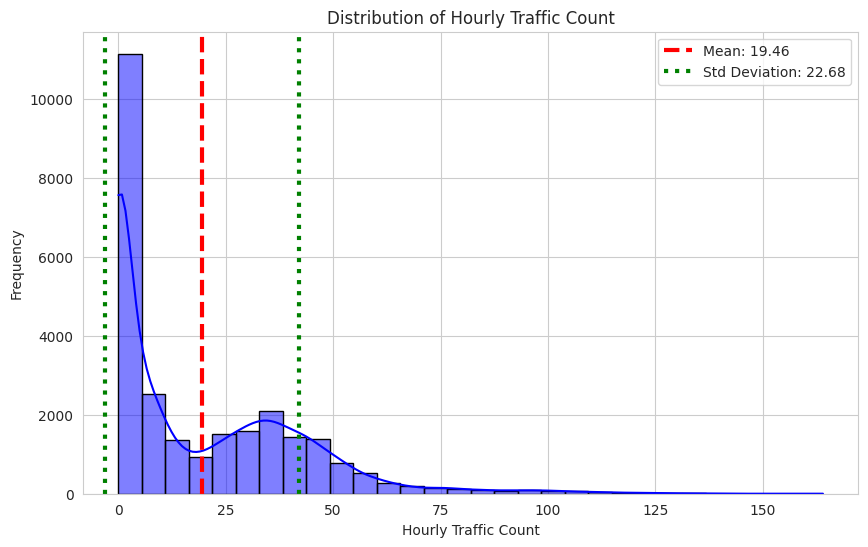

In [122]:
# Explore the distribution of hourly traffic using a histogram
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(traffic1, bins=30, color='blue', edgecolor='black', kde=True)
plt.title('Distribution of Hourly Traffic Count')
plt.xlabel('Hourly Traffic Count')
plt.ylabel('Frequency')
std_traffic = np.std(traffic1)
plt.axvline(mean_traffic, color='red', linestyle='dashed', linewidth=3, label=f'Mean: {mean_traffic:.2f}')
plt.axvline(mean_traffic - std_traffic, color='green', linestyle='dotted', linewidth=3, label=f'Std Deviation: {std_traffic:.2f}')
plt.axvline(mean_traffic + std_traffic, color='green', linestyle='dotted', linewidth=3)
plt.legend()

plt.show()


## Baseline Model Training

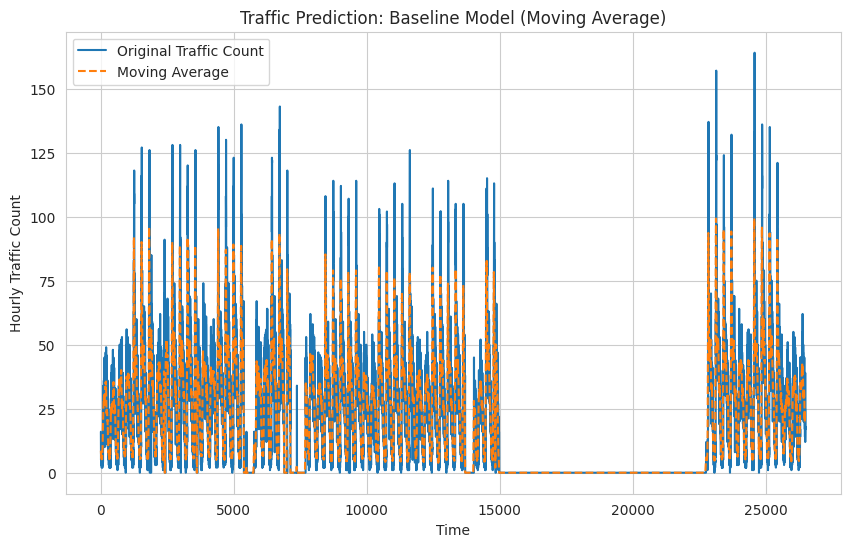

In [125]:
# Train a baseline model, to provide a simple benchmark to measure against
# Define window size for moving average
window_size = 24

# Ensure traffic1 is a one-dimensional array
traffic2 = np.array(traffic1).flatten()

# Calculate moving average
moving_average = np.convolve(traffic1, np.ones(window_size)/window_size, mode='valid')

# Plot original data and moving average
plt.figure(figsize=(10, 6))
plt.plot(traffic2, label='Original Traffic Count')
plt.plot(moving_average, label='Moving Average', linestyle='--')
plt.title('Traffic Prediction: Baseline Model (Moving Average)')
plt.xlabel('Time')
plt.ylabel('Hourly Traffic Count')
plt.legend()
plt.show()

Select the last 9600 rows (400 days)

In [128]:
traffic1 = traffic1[:9601]
traffic1.tail()

9596    76
9597    93
9598    80
9599    83
9600    97
Name: hourly_traffic_count, dtype: int64

# Preprocessing

Convert the dataset into input-output pairs  for training the model.

In [130]:
def create_dataset(dataset, window=1):
    dataX, dataY= [], []
    for i in range(len(dataset)-window-1):
        a = dataset[i:(i+window),0]
        dataX.append(a)
        dataY.append(dataset[i+window,0])
    return np.array(dataX), np.array(dataY)

 #Scale the features to improve the performance and stability of the model.

In [131]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic1 = scaler.fit_transform(np.array(traffic1).reshape(-1,1))

In [132]:
# Define the number of folds for cross-validation, initialize KFold
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
rmse_scores = []

# Perform k-fold cross-validation
for fold, (train_index, test_index) in enumerate(kf.split(traffic1)):
    print(f"Fold {fold + 1}/{num_folds}")

Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5


# Calculating Training and Test Sizes : train test split (80% train, 20% test)

In [133]:
training_size = int(len(traffic1)*0.80)
test_size = len(traffic1)-training_size


In [134]:
# Split the data into train and test sets for this fold
train_data, test_data = traffic1[0:training_size,:], traffic1[training_size:len(traffic1),:1]

In [135]:
# Split the data into train and test sets for this fold
window = 288
X_train, y_train = create_dataset(train_data, window)
X_test, y_test = create_dataset(test_data, window)

# Model Definition


In [136]:
# Define the model with L2 regularization
model = Sequential()
model.add(Dense(40, input_dim=window, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(50, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(40, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(1))

In [137]:
opt  = keras.optimizers.Adagrad(learning_rate = 0.05)

 Finalize the model's architecture and configuration for training

In [138]:
model.compile(optimizer=opt ,loss='mean_squared_error')

In [139]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 40)                11560     
                                                                 
 dense_13 (Dense)            (None, 50)                2050      
                                                                 
 dense_14 (Dense)            (None, 40)                2040      
                                                                 
 dense_15 (Dense)            (None, 1)                 41        
                                                                 
Total params: 15691 (61.29 KB)
Trainable params: 15691 (61.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


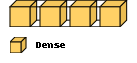

In [141]:
# visualize the sequential model
import visualkeras
visualkeras.layered_view(model,legend=True)

# Model training

In [142]:
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

# Model Prediction
Make predictions on both the training and testing datasets

In [143]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

51/51 [==============================] - 0s 2ms/step


# Reversing the scaling transformation to obtain values in their original scale before normalization

In [144]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [145]:
# Calculate RMSE for this fold
rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f"RMSE for Fold {fold + 1}: {rmse}")

# Store the RMSE score for this fold
rmse_scores.append(rmse)

RMSE for Fold 5: 7.0655038035212625


In [146]:
# Calculate the average RMSE across all folds
avg_rmse = np.mean(rmse_scores)
print(f"Average RMSE across all folds: {avg_rmse}")

Average RMSE across all folds: 7.0655038035212625


# Cast the predicted and the actual target values to integers for further analysis

In [147]:
train_predict = train_predict.astype(int)
test_predict = test_predict.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# Model Evaluation
Accuracy Measures


In [148]:
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
print('RMSE-train:',math.sqrt(mean_squared_error(y_train,train_predict)))
print('MAE-train:',mean_absolute_error(y_train,train_predict))
print('R_2-train:',r2_score(y_train,train_predict))

RMSE-train: 7.353779159074862
MAE-train: 4.790285482343391
R_2-train: 0.9037777671751606


In [149]:
print('RMSE-test:',math.sqrt(mean_squared_error(y_test,test_predict)))
print('MAE-test:',mean_absolute_error(y_test,test_predict))
print('R_2-test:',r2_score(y_test,test_predict))

RMSE-test: 7.0692911561895935
MAE-test: 4.836397058823529
R_2-test: 0.8859707932069114


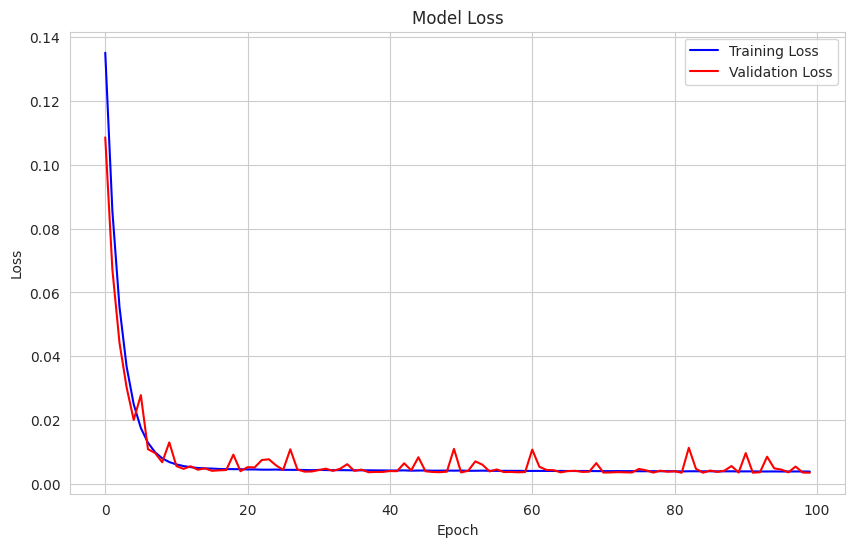

In [150]:
# Plot training and testing loss curves over epochs
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Visualize: original data along with the predictions made by the model

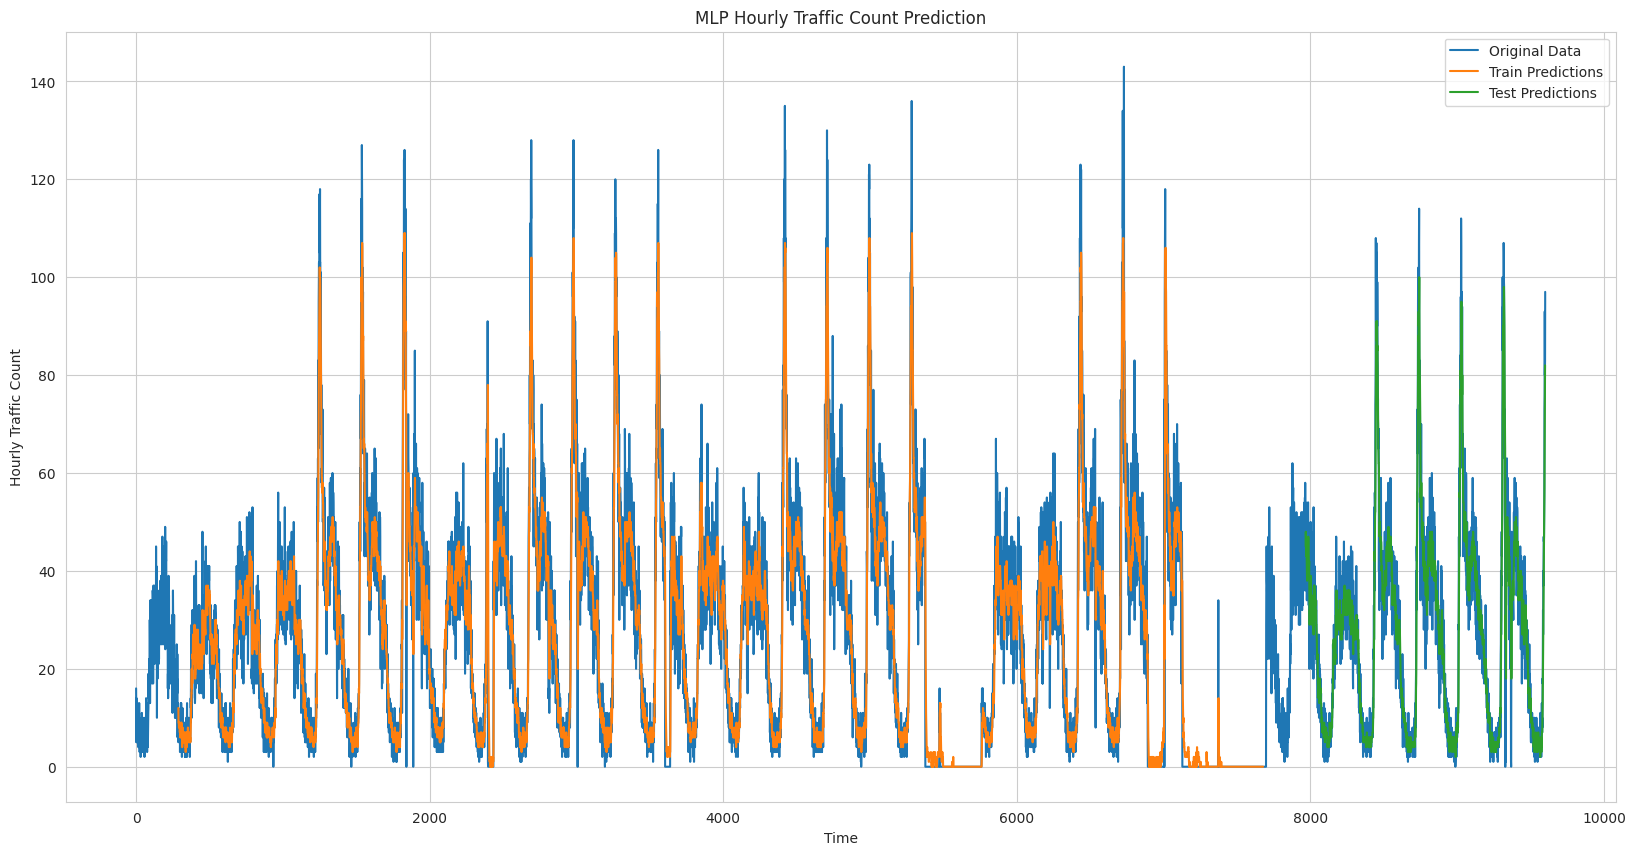

In [155]:
# Train predictions for plotting
trainPredictPlot = np.empty_like(traffic1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window:len(train_predict)+window, :] = train_predict

# Test predictions for plotting
testPredictPlot = np.empty_like(traffic1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(window*2)+1:len(traffic1)-1, :] = test_predict

# Plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(traffic1), label='Original Data')
plt.plot(trainPredictPlot, label='Train Predictions')
plt.plot(testPredictPlot, label='Test Predictions')
plt.xlabel('Time')
plt.ylabel('Hourly Traffic Count')
plt.title('MLP Hourly Traffic Count Prediction')
plt.legend()
plt.show()






# Improve model's predictive performance using an ensemble method

In [152]:
# implement bagging,an ensemble method
# Define the base estimator
base_estimator = DecisionTreeRegressor()

# Define the bagging regressor with 10 base estimators (trees)
bagging_model = BaggingRegressor(base_estimator=base_estimator, n_estimators=10, random_state=42)

# Train the bagging model and make predictions
bagging_model.fit(X_train, y_train)
y_pred_bagging = bagging_model.predict(X_test)

# Evaluate the bagging model
rmse_bagging = math.sqrt(mean_squared_error(y_test, y_pred_bagging))
print(f"RMSE of Bagging Model: {rmse_bagging}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:508: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


RMSE of Bagging Model: 7.599195729502835
